In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from mysql.connector import connect, Error
from math import ceil
import wget
import gzip
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Возрастные изменения метилирования и экспрессии в транспозонах

### Цель:
Построить таблицу метрики, показывающей процент метилирования CpG для всех доноров, усреднить по донорам для каждого LINE элемента и визуализировать

### Задачи:
* загрузить необходимые данные:
    * из базы ucsc по координатам LINE элементов
    * данные о частоте и глубине покрытия CpG
* загрузить и предобработать данные
* создать графу с указанием LINE, в который попадает каждый сайт
* для каждого LINE агрегировать всех его доноров по покрытиям и частоте
* расчитать значение метрики
* Усреднить значение метрики для каждого LINE по всем его донорам
* Визуализировать значение метрики для каждого LINE

### Ход работы

##### ========================
#### Вспомогательные функции
##### ========================

In [4]:
def download_hg19(file_path: str = 'lines_df.csv'):
    """
    Загружаем данные из БД в .csv файл по пути file_path
    """
    if not os.path.exists(file_path):
        try:
            with connect(host="genome-mysql.cse.ucsc.edu", user="genome", database="hg19") as connection:
                db_query = 'select chrom,chromStart,chromEnd,name from nestedRepeats where repClass="LINE" '
                with connection.cursor() as cursor:
                    cursor.execute(db_query)
                    lines = cursor.fetchall()

                    df_from_db = pd.DataFrame(lines)
                    df_from_db.columns = ['chr', 'start', 'stop', 'name']
                    df_from_db.to_csv(file_path, index=False)
        except Error as e:
            print(e)
    else:
        print('hg19 data is already downloaded!')


def bar_progress(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] MB" % (current / total * 100, current * 1e-6, total * 1e-6)
    sys.stdout.write("\r" + progress_message)
    sys.stdout.flush()      
        
        
def download_cytosines_data(freq_file_path: str = 'filtered_cytosines_freq.tsv.gz',
                            coverage_file_path: str = 'filtered_cytosines_coverage.tsv.gz',
                            broken_link_for_coverage: bool = False):
    """
    Загружаем таблицы с данными об уровне метилирования и покрытия CpG цитозинов
    
    ВНИМАНИЕ: на момент тестирования ссылка для скачивания файла filtered_cytosines_coverage не работала, 
    флаг coverage_broken_link отключает закачку этого файла, как только ссылка заработает - можно включить
    """
    
    url_freq = 'https://artyomovlab.wustl.edu/publications/supp_materials/aging/rrbs/filtered_cytosines_freq.tsv.gz'
    url_coverage = 'https://artyomovlab.wustl.edu/publications/supp_materials/aging/rrbs/filtered_cytosines_coverage.tsv.gz'
    
    if not os.path.exists(freq_file_path):
        wget.download(url_freq, out=freq_file_path, bar=bar_progress)
        print(' Freq data succesfully downloaded!')
    else:
        print('Freq file is already downloaded!')
    
    
    if not os.path.exists(coverage_file_path):
        if not broken_link_for_coverage:
            wget.download(url_coverage, out=coverage_file_path, bar=bar_progress)
            print(' Coverage data succesfully downloaded!')
        else:
            print('Sorry, the link is broken :(')
    else:
        print('Coverage data is already downloaded!')

### ===========================
### Загрузка необходимых файлов
### ===========================

In [5]:
download_hg19()
download_cytosines_data()

hg19 data is already downloaded!
Downloading: 100% [130 / 130] MB Freq data succesfully downloaded!
Downloading: 100% [118 / 118] MB Coverage data succesfully downloaded!


### =============
### Чтение данных
### =============

In [6]:
LINES_PATH = 'lines_df.csv'
COVERAGE_PATH = 'filtered_cytosines_coverage.tsv.gz'
FREQ_PATH = 'filtered_cytosines_freq.tsv.gz'

lines = pd.read_csv(LINES_PATH)

with gzip.open(COVERAGE_PATH) as f:
    cov_data = pd.read_csv(f, sep = '\t')
    
    # Уменьшаем объем занимаемой памяти, приводя данные к соответствующим типам
    numeric_cols = list(cov_data.columns[1:])
    for col in numeric_cols:
        cov_data[col] = cov_data[col].astype(dtype=pd.Int32Dtype())


with gzip.open(FREQ_PATH) as f:
    freq_data = pd.read_csv(f, sep = '\t')
    # Уменьшаем объем занимаемой памяти, приводя данные к соответствующим типам
    for col in numeric_cols:
        freq_data[col] = freq_data[col].astype(np.float16)



### ====================
### Предобработка данных
### ====================

#### Часть 1

In [7]:
# Отделяем хромосому от сайта

cov_data['chr'] = cov_data['chrBase'].apply(lambda x: str(x).split('.')[0])
cov_data['site'] = cov_data['chrBase'].apply(lambda x: int(str(x).split('.')[1]))
cov_data.drop('chrBase', inplace = True, axis=1)

freq_data['chr'] = freq_data['chrBase'].apply(lambda x: str(x).split('.')[0])
freq_data.drop('chrBase', inplace = True, axis=1)

# Оставляем только те LINE, которым соответствуют хромосомы из исходных данных
CHROMOSOMES = pd.unique(cov_data['chr'])

lines = lines[lines['chr'].isin(CHROMOSOMES)]
lines = lines.reset_index(drop=True)

#### Часть 2

##### Создадим в cov_data столбец с LINE, соответствующим каждому сайту

In [8]:
# Определим вспомогательный словарь, который будем использовать для быстрого поиска:

print('Preparing data...')

sl_dict = {c: {'sites': np.array(cov_data[cov_data['chr']==c]['site'])[:, np.newaxis],
               'starts': np.array(lines[lines['chr']==c]['start'])[np.newaxis, :],
               'stops': np.array(lines[lines['chr']==c]['stop'])[np.newaxis, :],
               'sites_inds': np.array(cov_data[cov_data['chr']==c].index),
               'lines_inds': np.array(lines[lines['chr']==c].index)} for c in tqdm(CHROMOSOMES)}

# Для каждой хромосомы выполним векторизованный поиск соответствия между сайтами и LINE
# Поиск ведется по мини-батчам для оптимального использования оперативной памяти

BATCH_SIZE = 2000

lines_for_chromes = dict()

print('Searching lines...')
for chrome in tqdm(sl_dict):
    n_batches = ceil(len(sl_dict[chrome]['sites']) / BATCH_SIZE)
    lines_for_sites = []
    print(f'Working on chromosome {chrome}:')
    for i in tqdm(range(n_batches - 1)):
        filtered_by_sites = (sl_dict[chrome]['sites'][i * BATCH_SIZE: (i + 1) * BATCH_SIZE] >= sl_dict[chrome]['starts']) & (sl_dict[chrome]['sites'][i * BATCH_SIZE: (i + 1) * BATCH_SIZE] < sl_dict[chrome]['stops'])
        batch_inds = np.argwhere(filtered_by_sites == True)
        
        # Переходим от относительной индексации батча к абсолютной (как в исходных датафреймах)
        batch_inds[:, 0] += i * BATCH_SIZE
        batch_inds[:, 0] = sl_dict[chrome]['sites_inds'][batch_inds[:, 0]]
        batch_inds[:, 1] = sl_dict[chrome]['lines_inds'][batch_inds[:, 1]]
        
        lines_for_sites.append(batch_inds)
        
    if lines_for_sites:
        lines_for_sites = np.vstack(lines_for_sites)
        lines_for_chromes[chrome] = lines_for_sites
    else:
        lines_for_chromes[chrome] = []
        

print('Adding new LINE column to cov_data...')

cov_data['LINE'] = -1  # так обозначим сайты, которые не попали ни в один LINE
for chrome in tqdm(CHROMOSOMES):
    if len(lines_for_chromes[chrome]) > 0:
        cov_index = lines_for_chromes[chrome][:, 0]
        lines_index = lines_for_chromes[chrome][:, 1]
        cov_data['LINE'][cov_index] = lines['name'][lines_index]
        
print('Data is prepared!')

Preparing data...


  0%|          | 0/25 [00:00<?, ?it/s]

Searching lines...


  0%|          | 0/25 [00:00<?, ?it/s]

Working on chromosome chr1:


  0%|          | 0/121 [00:00<?, ?it/s]

Working on chromosome chr10:


  0%|          | 0/64 [00:00<?, ?it/s]

Working on chromosome chr11:


  0%|          | 0/73 [00:00<?, ?it/s]

Working on chromosome chr12:


  0%|          | 0/61 [00:00<?, ?it/s]

Working on chromosome chr13:


  0%|          | 0/30 [00:00<?, ?it/s]

Working on chromosome chr14:


  0%|          | 0/43 [00:00<?, ?it/s]

Working on chromosome chr15:


  0%|          | 0/41 [00:00<?, ?it/s]

Working on chromosome chr16:


  0%|          | 0/75 [00:00<?, ?it/s]

Working on chromosome chr17:


  0%|          | 0/86 [00:00<?, ?it/s]

Working on chromosome chr18:


  0%|          | 0/28 [00:00<?, ?it/s]

Working on chromosome chr19:


  0%|          | 0/102 [00:00<?, ?it/s]

Working on chromosome chr2:


  0%|          | 0/93 [00:00<?, ?it/s]

Working on chromosome chr20:


  0%|          | 0/45 [00:00<?, ?it/s]

Working on chromosome chr21:


  0%|          | 0/21 [00:00<?, ?it/s]

Working on chromosome chr22:


  0%|          | 0/43 [00:00<?, ?it/s]

Working on chromosome chr3:


  0%|          | 0/61 [00:00<?, ?it/s]

Working on chromosome chr4:


  0%|          | 0/55 [00:00<?, ?it/s]

Working on chromosome chr5:


  0%|          | 0/60 [00:00<?, ?it/s]

Working on chromosome chr6:


  0%|          | 0/60 [00:00<?, ?it/s]

Working on chromosome chr7:


  0%|          | 0/78 [00:00<?, ?it/s]

Working on chromosome chr8:


  0%|          | 0/56 [00:00<?, ?it/s]

Working on chromosome chr9:


  0%|          | 0/65 [00:00<?, ?it/s]

Working on chromosome chrM:


0it [00:00, ?it/s]

Working on chromosome chrX:


  0%|          | 0/29 [00:00<?, ?it/s]

Working on chromosome chrY:


  0%|          | 0/2 [00:00<?, ?it/s]

Adding new LINE column to cov_data...


  0%|          | 0/25 [00:00<?, ?it/s]

<ipython-input-8-dfa665cc24ae>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cov_data['LINE'][cov_index] = lines['name'][lines_index]


Data is prepared!


### ==============
### Расчёт метрики
### ==============

In [9]:
line_counts = cov_data['LINE'].value_counts()
lines_with_more_4_sites = list(line_counts[line_counts >= 4].index)


DONOR_COLUMNS = ['OD10', 'OD11', 'OD12', 'OD13', 'OD14', 'OD15', 'OD16', 'OD17', 'OD18',
                 'OD19', 'OD1', 'OD20', 'OD2', 'OD3', 'OD4', 'OD5', 'OD6', 'OD7', 'OD8',
                 'OD9', 'YD10', 'YD11', 'YD12', 'YD14', 'YD15', 'YD16', 'YD17', 'YD18',
                 'YD19', 'YD1', 'YD20', 'YD21', 'YD2', 'YD3', 'YD4', 'YD5', 'YD6', 'YD7',
                 'YD8', 'YD9']

# Строим сводную таблицу: LINE / DONOR, агрегируем по сумме покрытий
# Значения этой таблицы будут в знаменателе нашей метрики
donors_cov_by_lines = pd.pivot_table(cov_data[cov_data['LINE'] != -1], values=DONOR_COLUMNS, index='LINE', aggfunc=np.sum)

# Строим сводную таблицу: LINE / DONOR, агрегируем по сумме взвешенных на частоты покрытий
# Значения этой таблицы будут в числителе нашей метрики
multiplied_freq_cov = freq_data[DONOR_COLUMNS] * cov_data[DONOR_COLUMNS] / 100
multiplied_freq_cov['LINE'] = cov_data['LINE']
multiplied_donors_by_lines = pd.pivot_table(multiplied_freq_cov[multiplied_freq_cov['LINE'] != -1], values=DONOR_COLUMNS, index='LINE', aggfunc=np.sum)

# Итоговая метрика
metrics = multiplied_donors_by_lines / donors_cov_by_lines

In [10]:
metrics

,OD1,OD10,OD11,OD12,OD13,OD14,OD15,OD16,OD17,OD18,...,YD2,YD20,YD21,YD3,YD4,YD5,YD6,YD7,YD8,YD9
LINE,,,,,,,,,,,,,,,,,,,,,
CR1_Mam,0.845388,0.880613,0.897176,0.895855,0.879373,0.888439,0.846110,0.853989,0.876037,0.881863,...,0.860958,0.908289,0.866508,0.848731,0.870281,0.893148,0.867420,0.876184,0.872924,0.857788
HAL1,0.849052,0.848448,0.869990,0.862601,0.842464,0.850615,0.842191,0.858584,0.847366,0.852020,...,0.841188,0.856818,0.848229,0.854840,0.848760,0.852903,0.854247,0.853969,0.848765,0.848970
HAL1-2a_MD,0.875000,0.950000,0.986875,1.000000,0.937500,1.000000,0.921250,0.965625,1.000000,0.895000,...,0.944375,0.941250,0.979375,0.970000,0.979375,0.961250,0.976250,0.978750,0.978750,0.986875
HAL1-3A_ME,0.934841,0.934289,0.915672,0.964956,0.908297,0.970368,0.954778,0.965764,0.932546,0.939168,...,0.917006,0.959027,0.923157,0.949051,0.929818,0.938050,0.916429,0.913598,0.937360,0.933807
HAL1b,0.746839,0.815397,0.789905,0.786384,0.782143,0.786019,0.808759,0.827028,0.774959,0.778598,...,0.775557,0.811926,0.741093,0.762000,0.800903,0.780444,0.802701,0.811261,0.796457,0.775643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X3_LINE,0.962235,1.000000,1.000000,1.000000,1.000000,0.942929,0.944375,0.931676,0.934837,1.000000,...,0.943278,0.956467,0.580575,1.000000,0.987179,0.881318,0.907856,0.882381,1.000000,0.916667
X5B_LINE,1.000000,0.937500,1.000000,1.000000,1.000000,0.964375,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.976250,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.950000
X6B_LINE,0.946250,0.990711,0.977639,0.980092,0.955937,0.968563,0.954932,0.988750,1.000000,0.955485,...,0.917705,0.986875,0.940712,0.952500,0.951883,0.971563,0.913619,0.933901,0.978842,0.966261


In [11]:
# Сохранение метрики в файл

metrics.to_csv(r'Metrics.csv')
# file = pd.read_csv('Metrics.csv').set_index('LINE')
# file

### ===================
### Визуализация метрики
### ===================

In [12]:
means_sorted = metrics.mean(axis=1).sort_values()

metr = np.array(means_sorted)
line_names = list(means_sorted.index)

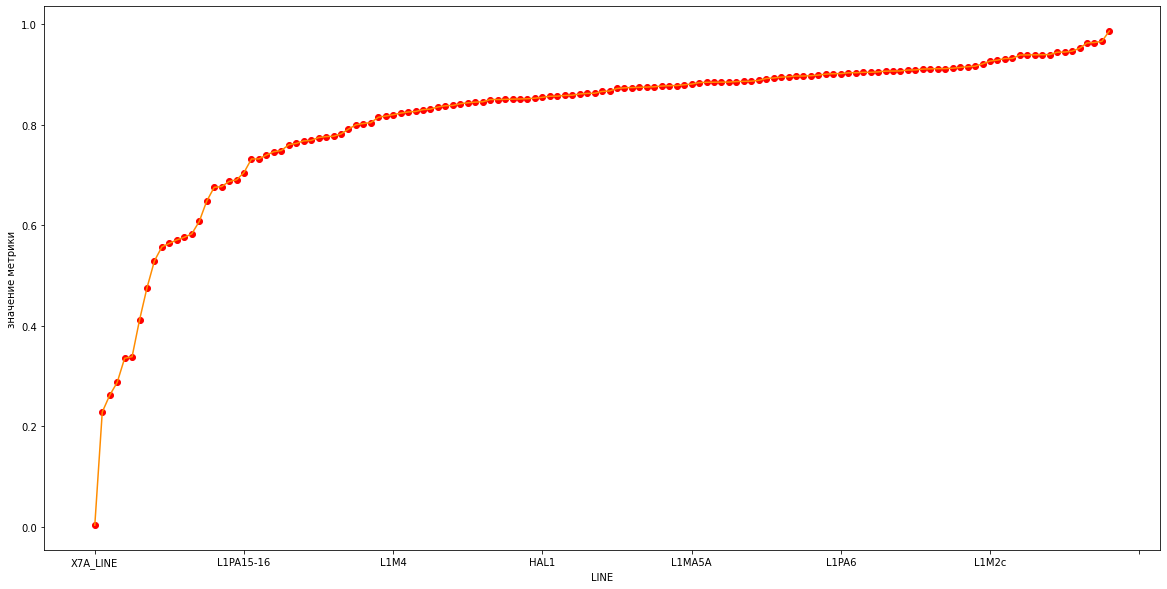

In [13]:
plt.figure(figsize=(20,10))
means_sorted.plot(color='darkorange')
plt.scatter(x=line_names, y=metr, color='red')
plt.ylabel('значение метрики')
plt.show()

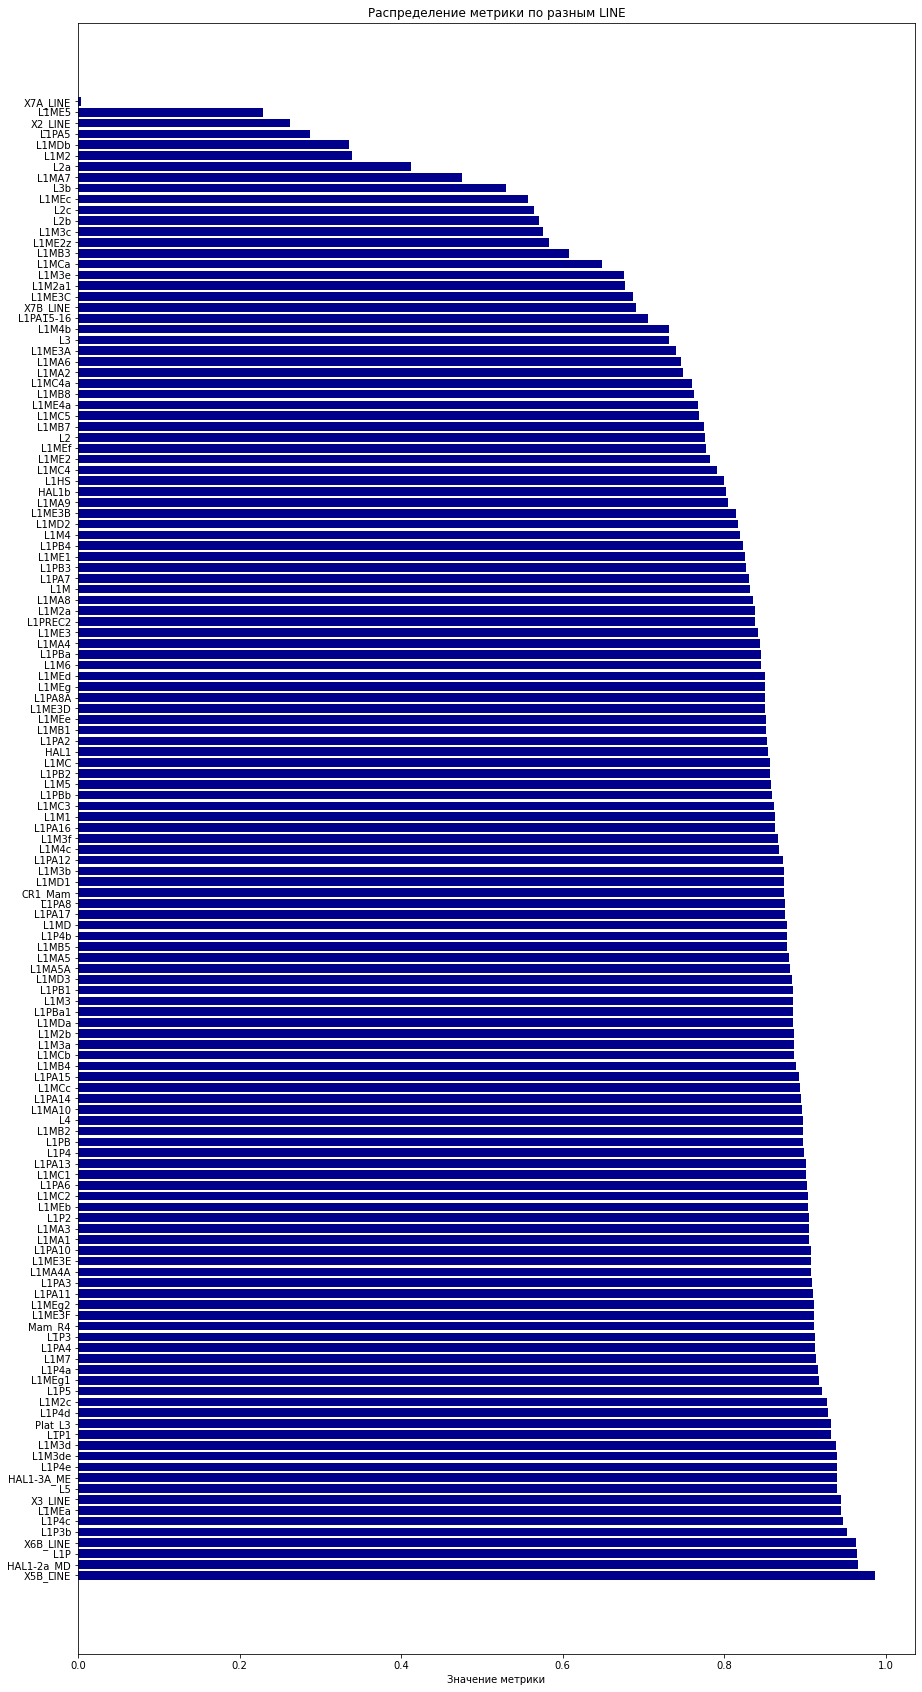

In [14]:
y_pos = np.arange(len(line_names))

fig, ax = plt.subplots(figsize=(15, 30))
ax.barh(y_pos, metr, align='center', color='darkblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(line_names)
ax.invert_yaxis()  # От меньших к большим
ax.set_xlabel('Значение метрики')
ax.set_title('Распределение метрики по разным LINE')
plt.show()